In [1]:
import os 
import pickle
import hashlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle 
from sklearn.metrics import accuracy_score
import seaborn as sns 

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, Dropout, Softmax
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.models import load_model

2024-09-12 20:06:08.938183: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-12 20:06:09.294263: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-09-12 20:06:09.294284: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-09-12 20:06:10.693094: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directo

## Load Data

#### Impoartant! 
Download the dataset locally from [OneDrive here](https://purdue0-my.sharepoint.com/personal/du245_purdue_edu/_layouts/15/onedrive.aspx?id=%2Fpersonal%2Fdu245%5Fpurdue%5Fedu%2FDocuments%2FShared%2FQSC%20ML%20for%20readout%2FFinal%5Fraw%5Fdata%5Ffor%5Fpaper%2Fdata%5F0528%5Fnpy). We are using QICK data with timestamp **0528**. 

In [2]:
def one_hot_encode(data):
    y_encoded = np.zeros([data.shape[0],2], dtype=np.int32)
    for idx, x in enumerate(data):
        if x == 1:
            y_encoded[idx][1] = 1
        else:
            y_encoded[idx][0] = 1
    return y_encoded

In [3]:
train_data_dir = "../data/malab_05282024/npz/"
test_data_dir = "../data/malab_05282024/npz/"
start_window = 0
end_window = 770

In [4]:
"""Loadning training split"""
x_train_path = os.path.join(train_data_dir, f'0528_X_train_0_770.npy')
y_train_path = os.path.join(train_data_dir, f'0528_y_train_0_770.npy')

assert os.path.exists(x_train_path), f"ERROR: File {x_train_path} does not exist."
assert os.path.exists(y_train_path), f"ERROR: File {y_train_path} does not exist."

X_train_val = np.load(x_train_path)
y_train_val = np.load(y_train_path)

# Insure same dataset is loaded 
assert hashlib.md5(X_train_val).hexdigest() == 'b61226c86b7dee0201a9158455e08ffb',  "Checksum failed. Wrong file was loaded or file may be corrupted."
assert hashlib.md5(y_train_val).hexdigest() == 'c59ce37dc7c73d2d546e7ea180fa8d31',  "Checksum failed. Wrong file was loaded or file may be corrupted."

# Get readout window
X_train_val = X_train_val[:,start_window*2:end_window*2]
y_train_val = one_hot_encode(y_train_val)
assert len(X_train_val[0]) == (end_window-start_window)*2, f"ERROR: X_test sample size {len(X_train_val[0])} does not match (start window, end window) ({start_window},{end_window}) size."


print("Train Data Set:")
print(f"  X Path : {x_train_path}")
print(f"  y Path : {y_train_path}")
print(f"  Size : {len(X_train_val):,}")
print(f"  Shape : {X_train_val[0].shape}")

Train Data Set:
  X Path : ../data/malab_05282024/npz/0528_X_train_0_770.npy
  y Path : ../data/malab_05282024/npz/0528_y_train_0_770.npy
  Size : 900,000
  Shape : (1540,)


In [5]:
"""Loading testing split"""
x_test_path = os.path.join(test_data_dir, f'0528_X_test_0_770.npy')
y_test_path = os.path.join(test_data_dir, f'0528_y_test_0_770.npy')

assert os.path.exists(x_test_path), f"ERROR: File {x_test_path} does not exist."
assert os.path.exists(y_test_path), f"ERROR: File {y_test_path} does not exist."

X_test = np.load(x_test_path)
y_test = np.load(y_test_path)

# Insure same dataset is loaded 
assert hashlib.md5(X_test).hexdigest() == 'b7d85f42522a0a57e877422bc5947cde', "Checksum failed. Wrong file was loaded or file may be corrupted."
assert hashlib.md5(y_test).hexdigest() == '8c9cce1821372380371ade5f0ccfd4a2', "Checksum failed. Wrong file was loaded or file may be corrupted."

# Get readout window
X_test = X_test[:,start_window*2:end_window*2]
y_test = one_hot_encode(y_test)
assert len(X_test[0]) == (end_window-start_window)*2, f"ERROR: X_test sample size {len(X_test[0])} does not match (start window, end window) ({start_window},{end_window}) size."


print("Test Data Set:")
print(f"  X Path : {x_test_path}")
print(f"  y Path : {y_test_path}")
print(f"  Size : {len(X_test):,}" )
print(f"  Sample Shape : {X_test[0].shape}")

Test Data Set:
  X Path : ../data/malab_05282024/npz/0528_X_test_0_770.npy
  y Path : ../data/malab_05282024/npz/0528_y_test_0_770.npy
  Size : 100,000
  Sample Shape : (1540,)


## Build our Model 
Architecture: input_shape -> 14 -> 2 (output)

In [6]:
def get_model(input_shape):
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(input_shape,)))
    model.add(BatchNormalization())
    model.add(Dense(2, activation='relu'))
    return model


input_shape = int((end_window-start_window)*2)
model = get_model(input_shape=input_shape)
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                98624     
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 2)                 130       
                                                                 
Total params: 99,010
Trainable params: 98,882
Non-trainable params: 128
_________________________________________________________________
None


2024-09-12 20:07:44.506253: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-09-12 20:07:44.506529: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2024-09-12 20:07:44.506598: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (correlator4.fnal.gov): /proc/driver/nvidia/version does not exist
2024-09-12 20:07:44.507429: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Scan Window Location and Size

In [13]:
"""hyperparameters"""
init_learning_rate = 1e-2
validation_split = 0.05  # 45,000 sample size 
batch_size = 1024
epochs = 150
early_stopping_patience = 15
checkpoint_filename = "multi-layer-hidden.h5"
checkpoint_dir = '../checkpoints/scan_window_location_and_size_h64'

assert os.path.exists(checkpoint_dir), f'ERROR: Checkpoint directory {checkpoint_dir} does not exist.'

# scan parameters 
all_window_start_locations = list(range(0, 351, 50))
# all_window_sizes = list(range(50, 401, 50))
all_window_sizes = list(range(50, 551, 50))
# all_window_sizes = list(range(50, 701, 50)) + [770]

print('Scanning window start locations:', all_window_start_locations)
print('Total locations:', len(all_window_start_locations))
print('Scanning window sizes:', all_window_sizes)
print('Total window sizes:', len(all_window_sizes))

Scanning window start locations: [0, 50, 100, 150, 200, 250, 300, 350]
Total locations: 8
Scanning window sizes: [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550]
Total window sizes: 11


In [8]:
all_e_accuracy = list() 
all_g_accuracy = list()
all_accuracy = np.zeros([len(all_window_sizes), len(all_window_start_locations)])
all_fidelity = np.zeros([len(all_window_sizes), len(all_window_start_locations)])

# 64 total runs 
for idx, window_size in enumerate(all_window_sizes):
    for jdx, start_location in enumerate(all_window_start_locations):
        #########################
        # 0. prep data 
        #########################
        # check if window size is too big for start location
        if start_location+window_size > 770:
            all_fidelity[idx, jdx] = -1
            print(f'Skipping start location={start_location}, window size={window_size}')
            continue
        X_train_val = np.load(x_train_path)  # need to load data again to avoid memory issues 
        X_test = np.load(x_test_path)
        X_train_val = X_train_val[:,start_location*2:(start_location+window_size)*2]
        X_test = X_test[:,start_location*2:(start_location+window_size)*2]

        #########################
        # 1. init callbacks
        #########################
        ckp_dir = os.path.join(checkpoint_dir, f'sl{start_location}_ws{window_size}')
        if os.path.exists(ckp_dir) == False: os.mkdir(ckp_dir)
        ckp_filename = os.path.join(ckp_dir, checkpoint_filename)
        callbacks = [
            ModelCheckpoint(
                ckp_filename,
                monitor="val_loss",
                verbose=0,
                save_best_only=True,
                save_weights_only=False,
                save_freq="epoch",
            ),
            EarlyStopping(
                monitor='val_loss',
                patience=early_stopping_patience,
                restore_best_weights=True,
            ),
        ]

        #########################
        # 2. declare model 
        #########################
        opt = Adam(learning_rate=init_learning_rate)
        model = get_model(input_shape=window_size*2)
        model.compile(
            optimizer=opt, 
            loss=CategoricalCrossentropy(from_logits=True), 
            metrics=['accuracy']
        )

        #########################
        # 3. train 
        #########################
        history = model.fit(
            X_train_val, 
            y_train_val, 
            batch_size=batch_size,
            epochs=epochs, 
            validation_split=validation_split, 
            shuffle=True, 
            callbacks=callbacks,
            verbose=0,
        )

        # Save the history dictionary
        with open(os.path.join(ckp_dir, 'training_history.pkl'), 'wb') as f:
            pickle.dump(history.history, f)

        # load best checkpoint point 
        model = load_model(ckp_filename)

        #########################
        # 4. compute fidelity 
        #########################
        y_pred = model.predict(X_test)
        test_acc = accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
        all_accuracy[idx, jdx] = test_acc
        all_fidelity[idx, jdx] = test_acc*2-1
        
        # # get ground and excited indices 
        # e_indices = np.where(np.argmax(y_test, axis=1) == 1)[0]
        # g_indices = np.where(np.argmax(y_test, axis=1) == 0)[0]

        # # separate ground and excited samples 
        # Xe_test = X_test_window[e_indices]
        # ye_test = np.argmax(y_test, axis=1)[e_indices]

        # Xg_test = X_test_window[g_indices]
        # yg_test = np.argmax(y_test, axis=1)[g_indices]

        # # compute total correct for excited state 
        # ye_pred = model.predict(Xe_test)
        # e_accuracy = accuracy_score(ye_test, np.argmax(ye_pred, axis=1))

        # total_correct = (ye_test==np.argmax(ye_pred, axis=1)).astype(np.int8).sum()
        # total_incorrect = (ye_test!=np.argmax(ye_pred, axis=1)).astype(np.int8).sum()

        # # compute total correct for ground state 
        # yg_pred = model.predict(Xg_test)
        # g_accuracy = accuracy_score(yg_test, np.argmax(yg_pred, axis=1))

        # total_correct = (yg_test==np.argmax(yg_pred, axis=1)).astype(np.int8).sum()
        # total_incorrect = (yg_test!=np.argmax(yg_pred, axis=1)).astype(np.int8).sum()

        # all_e_accuracy.append(e_accuracy)
        # all_g_accuracy.append(g_accuracy)

        # compute fidelity 
        # fidelity = 0.5*(e_accuracy + g_accuracy)
        # all_fidelity[jdx, idx] = fidelity
        print('\n===================================')
        print(f'Start location = {start_location}, Window size = {window_size}')
        print('    Accuracy', test_acc)
        print('    Fidelity', test_acc*2-1)


2024-09-12 20:07:55.355941: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 4104000000 exceeds 10% of free system memory.


3125/3125 [==============================] - 7s 2ms/step

Start location = 0, Window size = 600
    Accuracy 0.96161
    Fidelity 0.9232199999999999


2024-09-12 20:09:50.707621: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 4104000000 exceeds 10% of free system memory.


3125/3125 [==============================] - 7s 2ms/step

Start location = 50, Window size = 600
    Accuracy 0.96199
    Fidelity 0.92398


2024-09-12 20:11:44.497781: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 4104000000 exceeds 10% of free system memory.


3125/3125 [==============================] - 7s 2ms/step

Start location = 100, Window size = 600
    Accuracy 0.96101
    Fidelity 0.9220200000000001


2024-09-12 20:13:51.115612: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 4104000000 exceeds 10% of free system memory.


3125/3125 [==============================] - 7s 2ms/step

Start location = 150, Window size = 600
    Accuracy 0.95988
    Fidelity 0.9197599999999999
Skipping start location=200, window size=600
Skipping start location=250, window size=600
Skipping start location=300, window size=600
Skipping start location=350, window size=600


2024-09-12 20:15:57.446244: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 4446000000 exceeds 10% of free system memory.


3125/3125 [==============================] - 7s 2ms/step

Start location = 0, Window size = 650
    Accuracy 0.96165
    Fidelity 0.9233
3125/3125 [==============================] - 7s 2ms/step

Start location = 50, Window size = 650
    Accuracy 0.96176
    Fidelity 0.9235199999999999
3125/3125 [==============================] - 7s 2ms/step

Start location = 100, Window size = 650
    Accuracy 0.96088
    Fidelity 0.9217599999999999
Skipping start location=150, window size=650
Skipping start location=200, window size=650
Skipping start location=250, window size=650
Skipping start location=300, window size=650
Skipping start location=350, window size=650
3125/3125 [==============================] - 7s 2ms/step

Start location = 0, Window size = 700
    Accuracy 0.96178
    Fidelity 0.9235599999999999
3125/3125 [==============================] - 7s 2ms/step

Start location = 50, Window size = 700
    Accuracy 0.96171
    Fidelity 0.9234199999999999
Skipping start location=100, window si

In [11]:
outfile = '_2-layer_scan_window_size_and_location_window_size_600_770.npz'
note = f'Training data on 0528, readout fidelity with 2-layer NN, scanned window size and location, window size 770'

np.savez(
    os.path.join(checkpoint_dir, outfile), 
    accuracy = np.array(all_accuracy), 
    fidelity = np.array(all_fidelity), 
    all_window_start_locations=np.array(all_window_start_locations),
    all_window_sizes=np.array(all_window_sizes),
    note=note
)

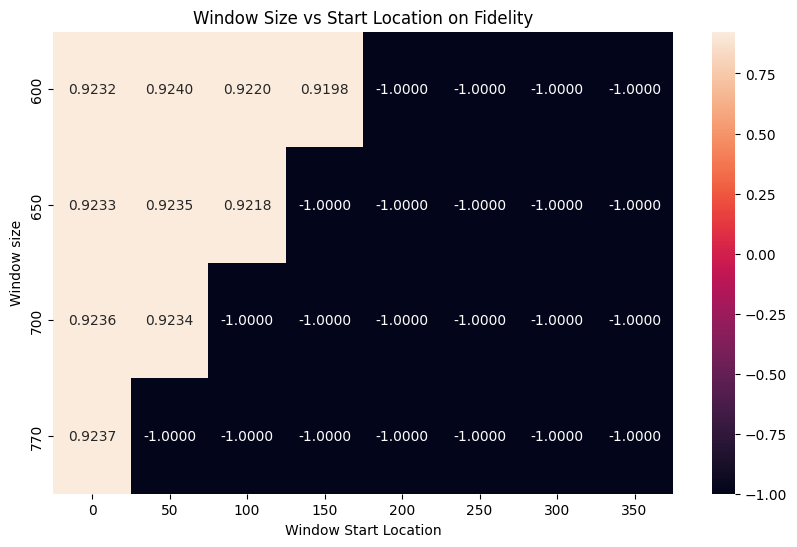

In [9]:
plt.figure(figsize=(10, 6))
sns.heatmap(all_fidelity, annot=True, fmt='.4f', yticklabels=all_window_sizes, xticklabels=all_window_start_locations)
plt.title('Window Size vs Start Location on Fidelity')
plt.xlabel('Window Start Location')
plt.ylabel('Window size')
plt.savefig(os.path.join(checkpoint_dir, 'window_size_vs_start_770.png'))

### Combine all runs 

In [67]:
data1 = np.load(os.path.join(checkpoint_dir, '_2-layer_scan_window_size_and_location.npz'))
data2 = np.load(os.path.join(checkpoint_dir, '_2-layer_scan_window_size_and_location_450_700.npz'))
data3 = np.load(os.path.join(checkpoint_dir, '_2-layer_scan_window_size_and_location_window_size_770.npz'))
data = np.concatenate((data1['fidelity'], data2['fidelity'], data3['fidelity']), 0)

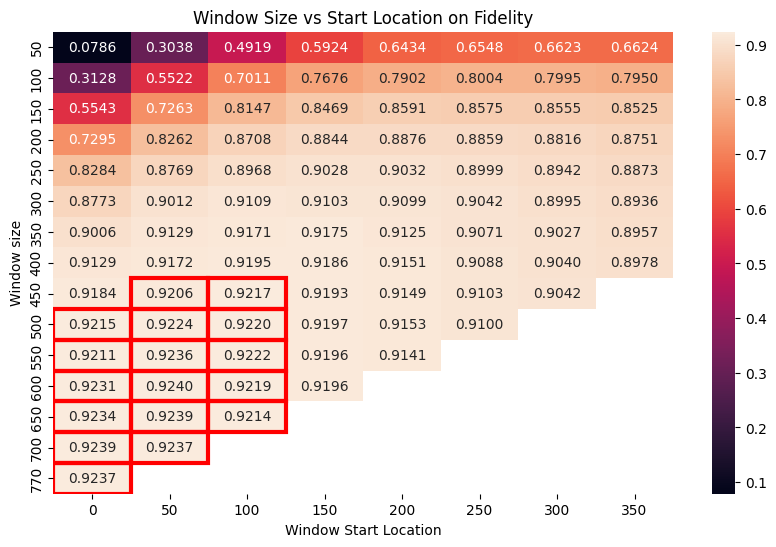

In [80]:
xi, yi = np.where(data > 0.92)
all_window_sizes = list(range(50, 701, 50)) + [770]

plt.figure(figsize=(10, 6))
ax = plt.gca()
sns.heatmap(data, annot=True, fmt='.4f', mask=np.isnan(data), yticklabels=all_window_sizes, xticklabels=all_window_start_locations)
for i in range(len(xi)):
    ax.add_patch(Rectangle((yi[i], xi[i]), 1, height=1, fill=False, edgecolor='red', lw=3))
plt.title('Window Size vs Start Location on Fidelity')
plt.xlabel('Window Start Location')
plt.ylabel('Window size')
plt.savefig(os.path.join(checkpoint_dir, 'window_size_vs_start_all.png'))